# Sistemas de recomendación: filtrado colaborativo

En este ejemplo utilizaremos el algoritmo de aprendizaje de filtrado colaborativo y lo aplicaremos a un dataset de valoraciones de películas.

Este dataset consiste en puntuaciones en la escala del 1 al 5. Se tienen 943 usuarios y 1682 peliculas.

#### Configuración de tamaño de gráficos

In [1]:
options(repr.plot.width=5, repr.plot.height=4, scipen = 999, warn = -1)

#### Instalación y carga de paquetes necesarios

In [2]:
list.of.packages <- c('R.matlab', 'ggmap', 'lbfgsb3', 'fields', 'png', 'IRdisplay')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(R.matlab)
library(ggmap)
library(lbfgsb3)
library(fields)
library(png)
library(IRdisplay)

R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: ggplot2
Loading required package: numDeriv
Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps

Attaching package: 'IRdisplay'

The following object is masked from 'package:spam':

    display



#### Carga y exploración de datos

In [5]:
mat <- as.matrix(as.data.frame(readMat('ex8_movies.mat')))

Y <- mat[,1:943]  #Contiene la valoración y(i,j) que dio un usuario i a una pelicula j.
R <- mat[,944:1886] #Contiene las valoraciones R(i,j)=0 si el usuario i valoró la pelicula j, y 0 si no la valoró.

cat('Cantidad de usuarios: ', ncol(Y))
cat('\nCantidad de películas: ', nrow(Y))

cat('\nCantidad de valoraciones: ', sum(R))

cat('\n\nProporción en el dataset según valoración: (0 corresponde a que el usuario no proporcionó valoración) ')
round(prop.table(table(Y)) * 100, 2)

cat('\n\nProporción en el dataset según valoración:')
round(prop.table(table(Y[Y!=0])) * 100, 2)

Cantidad de usuarios:  943
Cantidad de películas:  1682
Cantidad de valoraciones:  100000

Proporción en el dataset según valoración: (0 corresponde a que el usuario no proporcionó valoración) 

Y
    0     1     2     3     4     5 
93.70  0.39  0.72  1.71  2.15  1.34 



Proporción en el dataset según valoración:


    1     2     3     4     5 
 6.11 11.37 27.15 34.17 21.20 

Podemos ver que faltan casi el 94% de las valoraciones teniendo en cuenta películas y usuarios existentes. 
Si descartamos la proporción que no está valorada tenemos que el 35% corresponden a la valoración igual a 4, 27% para la 3, sigue la valoracion 5 con 21%, finalmente el 2 con 11%, y solo 6% está valorado con puntuación igual a 1.

### Histograma de ratings

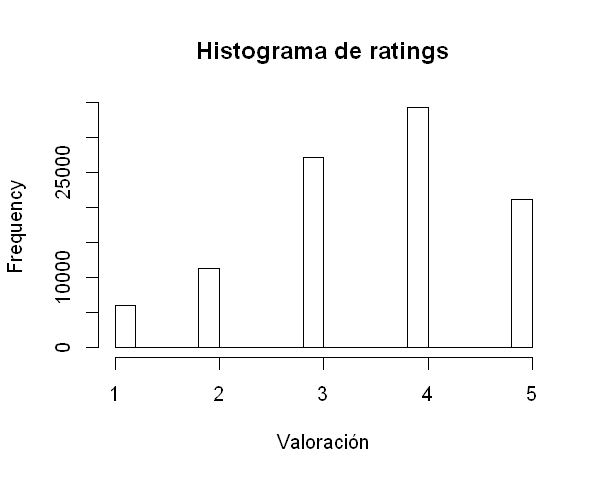

In [6]:
hist(Y[Y != 0], main = 'Histograma de ratings', xlab = 'Valoración')

Desde la matriz de ratings podemos calcular la valoración promedio de una pelicula por ej. Toy Story (que es la 1er pelicula).

In [10]:
cat('Valoración promedio Toy Story:', round(mean(Y[1, Y[1,] != 0]),2), '/ 5')

Valoración promedio Toy Story: 3.88 / 5

### Visualizamos la matriz de ratings para tener una noción de como se distribuyen los datos

png 
  2

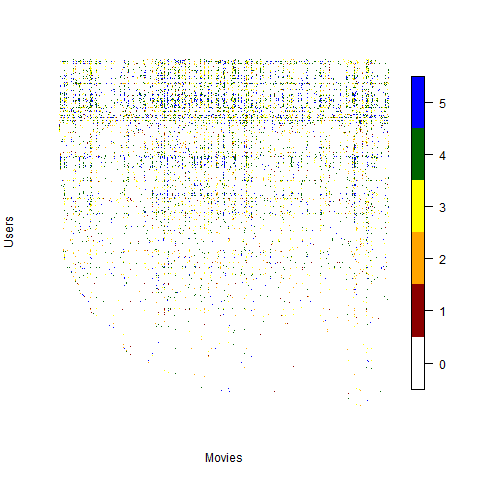

In [12]:
x <- 1:nrow(Y)
y <- 1:ncol(Y)
Y_temp <- apply(Y, 2, rev)
colores <- c('white', 'darkred', 'orange', 'yellow', 'darkgreen', 'blue')

png(filename = 'plot_ratings.png')
image.plot(y, x, t(Y_temp), xlab = 'Movies', ylab = 'Users', col = colores, axes = FALSE)
dev.off()

display_png(file='plot_ratings.png')

A partir del gráfico anterior podemos ver que toda la región blanca son películas sin valorar por los usuarios.
De igual forma se ve que los primeros usuarios son los que más indican los ratings de las películas vistas.

### A continuación visualizamos cada valoración por separado.

png 
  2

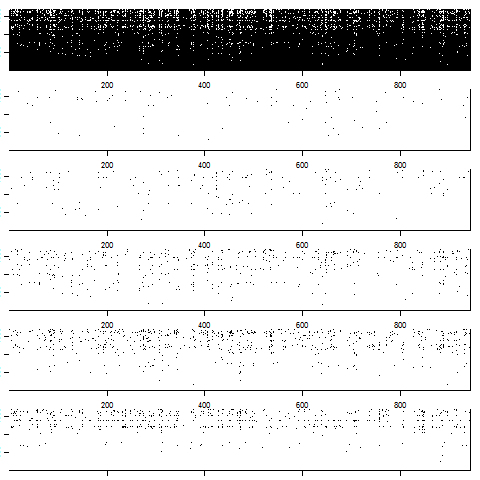

In [13]:
png(filename="plot_individuals_ratings.png")
par(mfrow = c(6,1), mar=c(1,1,1,1))

for(i in 0:5) {
    
    x <- 1:nrow(Y)
    y <- 1:ncol(Y)
    Y_temp <- Y == i
    Y_temp <- apply(Y_temp, 2, rev)
    image(y, x, t(Y_temp), xlab = 'Películas', ylab = 'Usuarios', col = c('white', 'black'), cex = 1.5)
}
dev.off()
par(mfrow = c(1,1))

display_png(file='plot_individuals_ratings.png')

El gráfico superior corresponde a las puntuaciones igual a 0. O sea, sin valoración. Como vimos anteriormente es mucho mayor la proporción sin valoraciones.
Los demás gráficos corresponden a las valoraciones 1 a 5 de arriba hacia abajo. Podemos ver las distribuciones de puntos y notar que para las valoraciones 1 y 2 no hay muchas puntuaciones, mientras que en las demás se ve una mayor cantidad de puntos.

### Función de costo del filtrado colaborativo

#### Cargamos los pesos pre-entrenados (X, Theta, num_users, num_movies, num_features)

In [ ]:
mat2 <- readMat('ex8_movieParams.mat')
str(mat2)

X <- mat2$X
Theta <- mat2$Theta
num_users <- mat2$num.users
num_movies <- mat2$num.movies
num_features <- mat2$num.features

#### Inicialmente reducimos el dataset para experimentar y obtener los resultados más rápido.

In [14]:
num_users <- 4
num_movies <- 5
num_features <- 3
X <- X[1:num_movies, 1:num_features]
Theta <- Theta[1:num_users, 1:num_features]
Y <- Y[1:num_movies, 1:num_users]
R <- R[1:num_movies, 1:num_users]
lambda <- 0

List of 5
 $ X           : num [1:1682, 1:10] 1.049 0.781 0.642 0.454 0.938 ...
 $ Theta       : num [1:943, 1:10] 0.2854 0.505 -0.4319 0.7286 0.0521 ...
 $ num.users   : num [1, 1] 943
 $ num.movies  : num [1, 1] 1682
 $ num.features: num [1, 1] 10
 - attr(*, "header")=List of 3
  ..$ description: chr "MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:16:53 2011                                                "
  ..$ version    : chr "5"
  ..$ endian     : chr "little"


#### Construimos las funciones para obtener el costo y los gradientes

In [11]:
cofiCostFunc <- function(params) {
    
    X <- matrix(params[1:(num_movies * num_features)], num_movies, num_features)
    Theta <- matrix(params[(num_movies * num_features + 1):length(params)],num_users, num_features)
    J <- 0
        
    hyp <- X %*% t(Theta)
    diff <- hyp - Y
    diff2 <- diff ^ 2
    
    J <- (1/2) * sum(sum(diff2 * R)) + (lambda / 2) * sum(sum(X ^ 2)) + (lambda / 2) * sum(sum(Theta ^ 2))
    J
}

cofiGradFunc <- function(params) {
    
    X <- matrix(params[1:(num_movies * num_features)], num_movies, num_features)
    Theta <- matrix(params[(num_movies * num_features + 1):length(params)],num_users, num_features)
    
    X_grad <- matrix(0,dim(X)[1],dim(X)[2])
    Theta_grad <- matrix(0, dim(Theta)[1], dim(Theta)[2])
    
    hyp <- X %*% t(Theta)
    diff <- hyp - Y
    diff2 <- diff ^ 2
    
    X_grad <- (diff * R) %*% Theta  + lambda * X
    Theta_grad <- t(diff * R) %*% X + lambda * Theta
    
    grad <- c(c(X_grad), c(Theta_grad))
    grad
}

J <- cofiCostFunc(c(c(X), c(Theta)))
grad <- cofiGradFunc(c(c(X), c(Theta)))

cat('Costo con los parámetros dados: ', J)

Costo con los parámetros dados:  22.2246

#### Probamos incrementando el valor de lambda

In [12]:
lambda <- 1.5
J <- cofiCostFunc(c(c(X), c(Theta)))
cat('Costo con los parámetros dados: ', J)

Costo con los parámetros dados:  31.34406

***
Una vez que experimentamos con unos pocos ratings pasamos a usar todo el dataset.

Antes de entrenar el modelo de filtrado colaborativo, primero añadiremos ratings que corresponden a un nuevo usuario.

##### Cargo los titulos de las películas

In [13]:
file_name <- 'movie_ids.txt'
file_contents <- readChar(file_name, file.info(file_name)$size)
movieList <- strsplit(file_contents, split = '\n')[[1]]
movieList <- gsub('^[0-9]+ ', '', movieList)
head(movieList)

[1] "Toy Story (1995)"                                    
[2] "GoldenEye (1995)"                                    
[3] "Four Rooms (1995)"                                   
[4] "Get Shorty (1995)"                                   
[5] "Copycat (1995)"                                      
[6] "Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)"

Inicializamos my_ratings

In [ ]:
my_ratings <- rep(0, 1682)

Por ejemplo, si queremos valorar a Toy Story con una puntuación de 4 y teniendo en cuenta que Toy Story es la primer pelicula del dataset, hacemos:

In [ ]:
my_ratings[1] <- 4

In [14]:
#Otras valoraciones
my_ratings[98] <- 2
my_ratings[7] <- 3
my_ratings[12] <- 5
my_ratings[54] <- 4
my_ratings[64] <- 5
my_ratings[66] <- 3
my_ratings[69] <- 5
my_ratings[183] <- 4
my_ratings[226] <- 5
my_ratings[355] <- 5

cat('Nuevas valoraciones del usuario: ')
for(i in 1:length(my_ratings)) {
    if(my_ratings[i] > 0) {
        cat('\nPuntuación', my_ratings[i], 'para', movieList[i])
    }
}

Nuevas valoraciones del usuario: 
Puntuación 4 para Toy Story (1995)
Puntuación 3 para Twelve Monkeys (1995)
Puntuación 5 para Usual Suspects, The (1995)
Puntuación 4 para Outbreak (1995)
Puntuación 5 para Shawshank Redemption, The (1994)
Puntuación 3 para While You Were Sleeping (1995)
Puntuación 5 para Forrest Gump (1994)
Puntuación 2 para Silence of the Lambs, The (1991)
Puntuación 4 para Alien (1979)
Puntuación 5 para Die Hard 2 (1990)
Puntuación 5 para Sphere (1998)

#### Ahora entrenaremos el modelo de filtrado colaborativo en el dataset de 1682 peliculas y 943 usuarios

Agregamos nuestros nuevos ratings al dataset

In [ ]:
mat <- as.matrix(as.data.frame(readMat('ex8_movies.mat')))

Y <- mat[,1:943]  #Contiene la valoración y(i,j) que dio un usuario i a una pelicula j.
R <- mat[,944:1886] #Contiene las valoraciones R(i,j)=0 si el usuario i valoró la pelicula j, y 0 si no la valoró.

Y <- cbind(Y, my_ratings)
R <- cbind(R, my_ratings != 0)

Normalizamos los ratings

In [15]:
#Y <- scale(Y)

Inicializamos algunos valores útiles

In [ ]:
num_users <- ncol(Y)
num_movies <- nrow(Y)
num_features <- 10

Inicializamos los parámetros de manera aleatoria

In [15]:
n <- num_movies * num_features
X <- matrix(rnorm(n), num_movies, num_features)
n <- num_users * num_features
Theta <-  matrix(rnorm(n), num_users, num_features)

initial_parameters <- c(c(X), c(Theta)) 

lambda <- 10  #para regularizar

#No es necesario calcular pero esto serían los gradientes y el costo inicial (en una iteración)
J <- cofiCostFunc(initial_parameters)
grad <- cofiGradFunc(initial_parameters)
cat('Costo inicial:', J)

[1] 1316871

#### Optimización: Utilizaremos la función optim() para minimizar

In [21]:
theta <- optim(initial_parameters, fn = cofiCostFunc, gr = cofiGradFunc, method = "BFGS", 
               control = list(maxit=1000, trace=1, REPORT=1) )$par

initial  value 1316870.654755 
iter   2 value 882206.306660
iter   3 value 776503.199029
iter   4 value 713265.664411
iter   5 value 651368.002121
iter   6 value 622027.335423
iter   7 value 588283.883247
iter   8 value 501477.298447
iter   9 value 472274.106860
iter  10 value 446823.632919
final  value 446823.632919 
stopped after 10 iterations


Redimensionamos los parámetros nuevamente

In [22]:
X <- matrix(theta[1:(num_movies*num_features)], num_movies, num_features)
Theta <- matrix(theta[(num_movies*num_features+1):length(theta)], num_users, num_features)

Luego de haber entrenado el modelo ahora podemos hacer recomendaciones calculando la matriz de predicciones

In [23]:
p <- X %*% t(Theta)
my_predictions <- p[,1] #sumar la media si estan normalizados los datos /escalados

**Obtenemos las mejores recomendaciones ordenando las predicciones.**

In [24]:
sorted <- sort(my_predictions, decreasing = TRUE, index.return = TRUE)
n <- 10
sorted <- lapply(sorted, "[", c(1:n)) 

cat('Mejores recomendaciones para ti:')
for(i in 1:n) {
    
    cat('\nPredicción de', sorted$x[i], 'de rating para la pelicula', movieList[sorted$ix[i]])
}

Mejores recomendaciones para ti:
Predicción de 10.83425 de rating para la pelicula Toy Story (1995)
Predicción de 10.29489 de rating para la pelicula Scream (1996)
Predicción de 10.19779 de rating para la pelicula Return of the Jedi (1983)
Predicción de 8.148821 de rating para la pelicula Raiders of the Lost Ark (1981)
Predicción de 7.897076 de rating para la pelicula Independence Day (ID4) (1996)
Predicción de 7.199577 de rating para la pelicula Back to the Future (1985)
Predicción de 6.9699 de rating para la pelicula Empire Strikes Back, The (1980)
Predicción de 6.831793 de rating para la pelicula Rock, The (1996)
Predicción de 6.354125 de rating para la pelicula Phenomenon (1996)
Predicción de 6.333214 de rating para la pelicula Schindler's List (1993)